<a href="https://colab.research.google.com/github/TannerLow/medical-image-calssifier/blob/main/ML_project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetching the dataset automatically
This does some setup to prepare the system to use kaggle's API and then downloads the dataset using kaggle's API all through code.

In [1]:
! mkdir .kaggle
! mv .kaggle /root/.kaggle
file = open('/root/.kaggle/kaggle.json', 'w')
file.write('{"username":"name9006","key":"59f18906073eb34224a05e9c03ad8607"}')
file.close()
! kaggle datasets download -d andrewmvd/medical-mnist 

 97% 82.0M/84.8M [00:00<00:00, 80.9MB/s]
100% 84.8M/84.8M [00:01<00:00, 87.3MB/s]


# Data preprocessing

In [ ]:
!unzip "medical-mnist.zip" -d "medical-mnist"

/content/medical-mnist/AbdomenCT/003916.jpeg


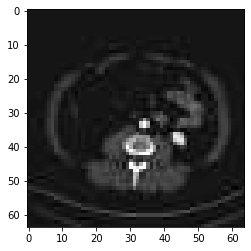

In [24]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import cv2

DATADIR = "/content/medical-mnist"
CATEGORIES = ["AbdomenCT","BreastMRI","CXR","ChestCT","Hand","HeadCT"]

for category in CATEGORIES:
  path = os.path.join(DATADIR, category) #Gets us into the path of the different categories
  for img in os.listdir(path):
    print(os.path.join(path, img))
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap="gray")
    plt.show()
    break # break to stop after displaying one image
  break

In [ ]:
print(img_array.shape)

(64, 64)


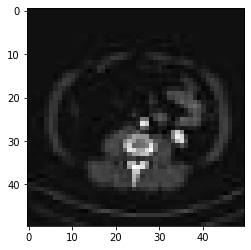

In [25]:
IMG_SIZE = 50

new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
plt.imshow(new_array, cmap = "gray")
plt.show()

Store image data with label into an array

In [26]:
def create_training_data():
  training_data = []
  counts = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category) #Gets us into the path of the different categories
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
        training_data.append([new_array, class_num])
        counts[class_num] += 1
      except Exception as e:
        pass
  print(counts)
  return training_data

In [27]:
training_data = create_training_data()

{0: 10000, 1: 8954, 2: 10000, 3: 10000, 4: 10000, 5: 10000}


In [28]:
#seeing how many images are in the training data currently (All images from the set currently)
print(len(training_data))

58954


In [29]:
#Shuffle the data so that is randomized and can learn better
np.random.seed(42)
np.random.shuffle(training_data)

In [30]:
for sample in training_data[:10]:
  print(sample[1])

0
0
4
3
2
0
0
4
0
1


In [31]:
X = []
y = []

In [32]:
for features, label in training_data:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [33]:
import pickle 

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [34]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

Load the data into arrays

In [35]:
import pickle

X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

X = np.array(X)
y = np.array(y)

Unpack the data into training, validation, and test sets.

In [36]:
X = X/255.0

X_train_full, X_test = X[:-5000], X[-5000:]
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]

y_train_full, y_test = y[:-5000], y[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

print("Full training dataset shape:", X_train_full.shape)
print("Test dataset shape:", X_test.shape)
print("Training dataset shape:", X_train.shape)
print("Validation dataset shape:", X_valid.shape)
print()

print("Full training labelset shape:", y_train_full.shape)
print("Test labelset shape:", y_test.shape)
print("Training labelset shape:", y_train.shape)
print("Validation labelset shape:", y_valid.shape)


Full training dataset shape: (53954, 50, 50, 1)
Test dataset shape: (5000, 50, 50, 1)
Training dataset shape: (48954, 50, 50, 1)
Validation dataset shape: (5000, 50, 50, 1)

Full training labelset shape: (53954,)
Test labelset shape: (5000,)
Training labelset shape: (48954,)
Validation labelset shape: (5000,)


#Creation of first model

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D


In [59]:
#Creating our CNN 
cnn = Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=7, activation="relu", padding = "same", input_shape = X.shape[1:]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) #Pooling 2
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding = "same")) #Convolution 2
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) #Pooling 2
cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding = "same")) #Convolution 4
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) #Pooling 3
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding = "same")) #Convolution 4
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) #Pooling 3
cnn.add(tf.keras.layers.Flatten()) #Flaterning
cnn.add(tf.keras.layers.Dense(units=128, activation="relu"))#Full Connection1
tf.keras.layers.Dropout(0.5)
cnn.add(tf.keras.layers.Dense(units=64, activation="relu"))#Full Connection2
tf.keras.layers.Dropout(0.5)
cnn.add(tf.keras.layers.Dense(units= 6, activation= "softmax"))#Output layer

cnn.compile(loss = "sparse_categorical_crossentropy",
              optimizer="adam",
              metrics = ["accuracy"])



In [60]:
cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 50, 50, 64)        3200      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 6, 6, 256)       

In [61]:
cnn.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=100, epochs=10)


Epoch 1/10
490/490 [==============================] - 24s 47ms/step - loss: 0.0855 - accuracy: 0.9716 - val_loss: 0.0101 - val_accuracy: 0.9976
Epoch 2/10
490/490 [==============================] - 22s 46ms/step - loss: 0.0095 - accuracy: 0.9977 - val_loss: 0.0053 - val_accuracy: 0.9990
Epoch 3/10
490/490 [==============================] - 22s 45ms/step - loss: 0.0117 - accuracy: 0.9975 - val_loss: 0.0026 - val_accuracy: 0.9994
Epoch 4/10
490/490 [==============================] - 22s 45ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0082 - val_accuracy: 0.9986
Epoch 5/10
490/490 [==============================] - 22s 45ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0036 - val_accuracy: 0.9994
Epoch 6/10
490/490 [==============================] - 22s 44ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0060 - val_accuracy: 0.9992
Epoch 7/10
490/490 [==============================] - 22s 44ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0029 - val_accuracy:

In [62]:
score = cnn.evaluate(X_test, y_test)
print('Total loss on testing set:', score[0])
print('Accuracy on testing set:', score[1])

157/157 [==============================] - 2s 11ms/step - loss: 2.8293e-04 - accuracy: 1.0000
Total loss on testing set: 0.000282929657259956
Accuracy on testing set: 1.0


In [63]:
X_new = X_test[:10]
y_pred = np.argmax(cnn.predict(X_new), axis=-1)
print("Prediction:", y_pred)
y_new = y_test[:10]
print("Actual    :", y_new)

Prediction: [1 1 2 5 3 3 5 1 2 4]
Actual    : [1 1 2 5 3 3 5 1 2 4]


#Creation of second model

Data format needs to be slightly altered to work with a feed forward network. X needs to be 2 dimensional and y needs to be one hot encoded.

In [ ]:
X_train = X_train.squeeze()
X_valid = X_valid.squeeze()
X_test = X_test.squeeze()

In [ ]:
# y_train
shape = (y_train.size, y_train.max()+1)
one_hot = np.zeros(shape)
rows = np.arange(y_train.size)
one_hot[rows, y_train] = 1
y_train_one_hot = one_hot

#y_valid
shape = (y_valid.size, y_valid.max()+1)
one_hot = np.zeros(shape)
rows = np.arange(y_valid.size)
one_hot[rows, y_valid] = 1
y_valid_one_hot = one_hot

#y_test
shape = (y_test.size, y_test.max()+1)
one_hot = np.zeros(shape)
rows = np.arange(y_test.size)
one_hot[rows, y_test] = 1
y_test_one_hot = one_hot

In [ ]:
print(X_train.shape[1:])

(50, 50)


In [ ]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Flatten(input_shape=X.shape[1:]))
model2.add(tf.keras.layers.Dense(units=500, activation="sigmoid"))
model2.add(tf.keras.layers.Dense(units=200, activation="sigmoid"))
model2.add(tf.keras.layers.Dense(units=6, activation="softmax"))

In [ ]:
model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 2500)              0         
                                                                 
 dense_85 (Dense)            (None, 500)               1250500   
                                                                 
 dense_86 (Dense)            (None, 200)               100200    
                                                                 
 dense_87 (Dense)            (None, 6)                 1206      
                                                                 
Total params: 1,351,906
Trainable params: 1,351,906
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics=["accuracy"])

In [ ]:
model2.fit(X_train, y_train_one_hot, validation_data=(X_valid, y_valid_one_hot), batch_size=100, epochs=25)

Epoch 1/25
490/490 [==============================] - 4s 7ms/step - loss: 0.1430 - accuracy: 0.9598 - val_loss: 0.0382 - val_accuracy: 0.9922
Epoch 2/25
490/490 [==============================] - 3s 6ms/step - loss: 0.0330 - accuracy: 0.9921 - val_loss: 0.0280 - val_accuracy: 0.9938
Epoch 3/25
490/490 [==============================] - 3s 6ms/step - loss: 0.0175 - accuracy: 0.9956 - val_loss: 0.0181 - val_accuracy: 0.9958
Epoch 4/25
490/490 [==============================] - 3s 6ms/step - loss: 0.0146 - accuracy: 0.9960 - val_loss: 0.0129 - val_accuracy: 0.9960
Epoch 5/25
490/490 [==============================] - 3s 6ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.0219 - val_accuracy: 0.9938
Epoch 6/25
490/490 [==============================] - 3s 6ms/step - loss: 0.0085 - accuracy: 0.9976 - val_loss: 0.0163 - val_accuracy: 0.9956
Epoch 7/25
490/490 [==============================] - 3s 6ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.0117 - val_accuracy: 0.9966
Epoch 

In [ ]:
score = model2.evaluate(X_test, y_test_one_hot)
print('Total loss on testing set:', score[0])
print('Accuracy on testing set:', score[1])

157/157 [==============================] - 1s 4ms/step - loss: 0.0051 - accuracy: 0.9984
Total loss on testing set: 0.005107399076223373
Accuracy on testing set: 0.9983999729156494


Prediction: [1 1 2 5 3 3 5 1 2 4]
Actual    : [1 1 2 5 3 3 5 1 2 4]


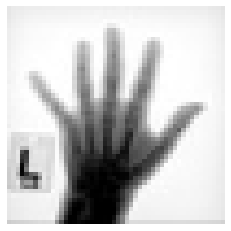

In [ ]:
X_new = X_test[:10]
y_pred = np.argmax(model2.predict(X_new), axis=-1)
print("Prediction:", y_pred)
y_new = np.array([np.argmax(value) for value in y_test_one_hot[:10]])
print("Actual    :", y_new)

plt.imshow(X_new[-1], cmap="binary")
plt.axis('off')
plt.show()